# Demand Forecasting Using Exponential Smoothing

In this notebook, we develop reference models for demand forecasting and decomposition using exponential smoothing.

See `_basic-components/time-series` folder for more time series models that can be applied to demand forecasting. Among the traditional time series models, exponential smooting and ARIMA are the two most common methods used in the demand forecasting practice. Both methods are particular cases of state space modeling (SSM). Among the modern demand forecasting methods, Bayesian structural time series (SSM) and sequence-to-sequence models such as RNNs and transformers are the most common choices.  

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
pd.options.mode.chained_assignment = None
plt.rcParams.update({'pdf.fonttype': 'truetype'})

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import platform
print(f'Python {platform.python_version()}')

p = sns.color_palette()

Python 3.10.2


# Data

We use a simple time series that is derived from the public Superstore Sales Data (see `datasets.md` for more details). 
* The time series consists of montly sales numbers for one of the retail categories, 48 consecutive months in total. 
* Each value is the average daily number of orders during the corresponding month.

In [16]:
data = [
 480.19,  378.56,  878.56,  599.39,  474.59,  748.24,
 664.98,  531.98,  1077.45, 864.75,  1086.60, 1649.31,
 1105.97, 660.68,  930.16,  965.39,  795.20,  609.41,
 911.18,  804.53,  1595.55, 856.38,  1520.74, 1294.03,
 763.49,  622.81,  886.16,  982.60,  985.13,  1125.42,
 1087.87, 1064.08, 1476.37, 975.93,  1633.04, 1783.05,
 780.57,  921.78,  948.92,  868.18,  1103.83, 1262.63,
 1009.32, 1315.32, 1677.58, 1354.08, 1767.17, 1756.29
]
index = pd.date_range(start="2014-01", end="2017-12", freq="MS")
data_s = pd.Series(data, index)
data_s = data_s[-36:] # select a shorter range for the modeling purposes 

# Simple Exponential Smoothing

We start with fitting the basic exponential smoothing model and producing the forecast.

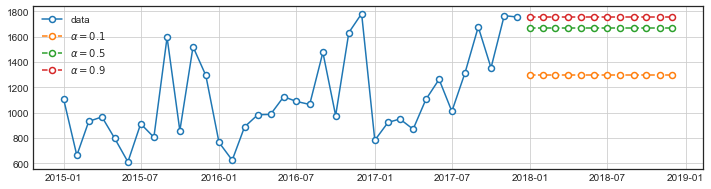

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(data_s, marker="o", markerfacecolor='white', markeredgewidth=1.5)
alphas = [0.1, 0.5, 0.9]
for alpha in alphas:
    model = SimpleExpSmoothing(data_s, initialization_method="estimated").fit(smoothing_level=alpha)
    forecast= model.forecast(12)
    ax.plot(forecast, marker='o', linestyle='--', markerfacecolor='white', markeredgewidth=1.5)
ax.legend(['data'] + [r"$\alpha=%s$" % a for a in alphas])
ax.grid(True)

# Double Exponetial Smoothing (Holt's Method)

Next, we fit the double exponential smoothing (Holt's) model.

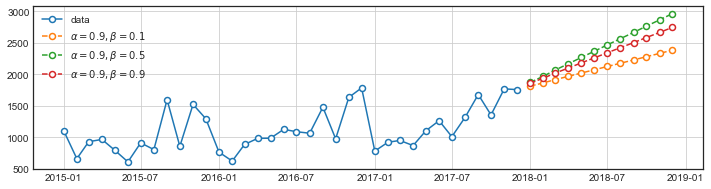

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(data_s, marker="o", markerfacecolor='white', markeredgewidth=1.5)
alpha = 0.9
betas = [0.1, 0.5, 0.9]
for beta in betas:
    model = Holt(data_s, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta)
    forecast= model.forecast(12)
    ax.plot(forecast, marker='o', linestyle='--', markerfacecolor='white', markeredgewidth=1.5)
ax.legend(['data'] + [r"$\alpha=%s, \beta=%s$" % (alpha, b) for b in betas])
ax.grid(True)

# Triple Exponential Smoothing (Holt-Winters' Method)

Next, we fit the triple exponential smoothing (Holt-Winters') model.

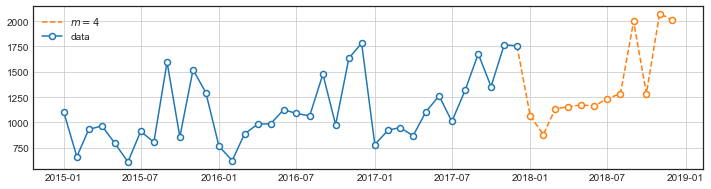

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
model = ExponentialSmoothing(data_s, 
        seasonal_periods=12,
        trend="add",
        seasonal="add",
        use_boxcox=True).fit()
forecast= model.forecast(12)
ax.plot(pd.concat([data_s[-1:], forecast[:1]]), linestyle='--', color=p[1])
ax.plot(data_s, marker="o", markerfacecolor='white', markeredgewidth=1.5)
ax.plot(forecast, marker='o', linestyle='--', markerfacecolor='white', markeredgewidth=1.5)
ax.legend(['$m=4$', 'data'])
ax.grid(True)

# Probabilistic Forecast

The exponential smoothing models allows to estimate the variance of the forecast analytically. This estimate then can be used to draw the forecast samples from the distribution parametrized by the mean and variance. The confidence intervals and other statistics can be calculated based on the drawn samples.

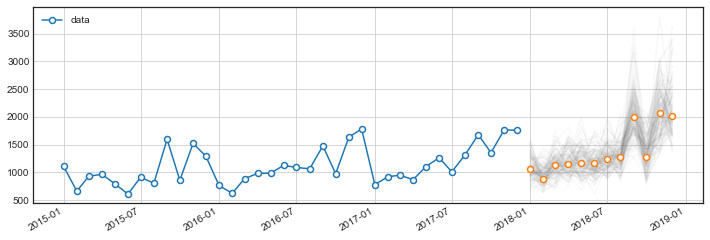

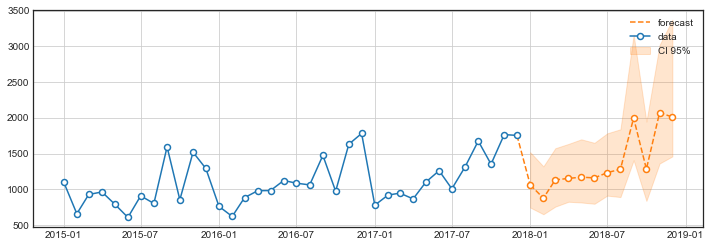

In [15]:
model = ExponentialSmoothing(data_s, 
        seasonal_periods=12,
        trend="add",
        seasonal="add",
        use_boxcox=True).fit()
forecast= model.forecast(12)
simulations = model.simulate(12, repetitions=100, error="add")

#
# Simulation
#
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(data_s, marker="o", markerfacecolor='white', markeredgewidth=1.5)
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
ax.plot(forecast, marker='o', linestyle='None', markerfacecolor='white', markeredgewidth=1.5)
ax.legend(['data'])
ax.grid(True)

#
# Confidence intervals
#
upper_ci = simulations.quantile(q=0.975, axis='columns')
lower_ci = simulations.quantile(q=0.025, axis='columns')
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(pd.concat([data_s[-1:], forecast[:1]]), linestyle='--', color=p[1])
ax.plot(data_s, marker="o", markerfacecolor='white', markeredgewidth=1.5)
ax.fill_between(forecast.index, lower_ci[-12:], upper_ci[-12:], alpha=0.2, color=p[1])
ax.plot(forecast, marker='o', linestyle='--', markerfacecolor='white', markeredgewidth=1.5)
ax.legend(['forecast', 'data', 'CI 95%'])
ax.grid(True)

# Decomposition

The exponential smooting models represent the time series as a superposition of components with clear semantic meaning such as level, trend, and seasonality. These components can be visualized to provide insights into the structure of the series.

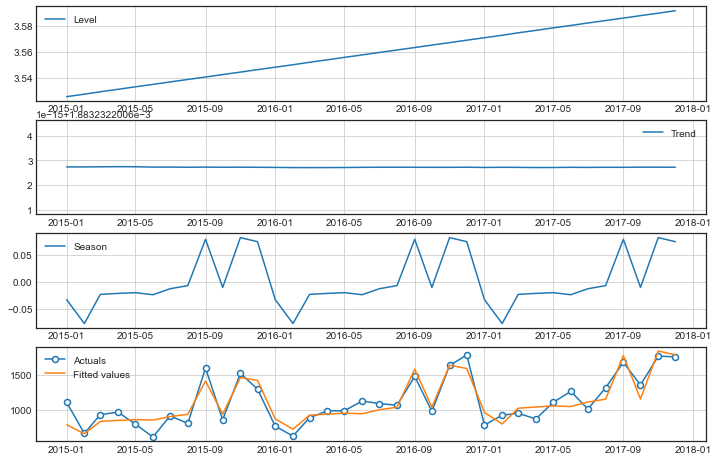

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
ax[0].plot(model.level, label='Level')
ax[1].plot(model.trend, label='Trend')
ax[2].plot(model.season, label='Season')
ax[3].plot(data_s, label='Actuals', marker="o", markerfacecolor='white', markeredgewidth=1.5)
ax[3].plot(model.fittedvalues, label='Fitted values')
for i in range(len(ax)):
    ax[i].grid(True)
    ax[i].legend()
plt.show()